<a href="https://colab.research.google.com/github/poojagpta/releases/blob/master/m5_forecasting_project/walmart_ts_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.pandas.set_option("display.max_columns",None)
import statsmodels.api as sm
from tqdm.notebook import tqdm
from statsmodels.tsa.arima.model import ARIMA

import pmdarima as pm


In [123]:
#!pip install --upgrade patsy
#!pip install --upgrade statsmodels

#!pip install pmdarima
#!pip install --upgrade sklearn

In [3]:
cal_df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/m5-forecasting-accuracy/calendar.csv")
df= pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/m5-forecasting-accuracy/sales_train_validation.csv")
price_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/m5-forecasting-accuracy/sell_prices.csv")

**Using top down approach**

Create a timeseries at walmart level

In [4]:
model_df = pd.DataFrame(np.array([[c for c in df.columns if c.find("d_") == 0] ,\
                                    df[[c for c in df.columns if c.find("d_") == 0]].sum()]).transpose(),\
                           columns=['d','unit_sale'] ,index=[c for c in df.columns if c.find("d_") == 0])

model_df['unit_sale']=model_df['unit_sale'].astype(float)

In [5]:
model_df=model_df.merge(cal_df, on='d', how="inner")

In [6]:
model_df['date'] = pd.to_datetime(model_df['date'])
model_df.set_index('date', inplace=True)

Timeseries random walk or can be predictable/stationary 

Note: In eda notebook, acf and pacf plot doesn't indicate if AR or MA or ARMA model.

**Hypothesis:**

H0: Timeseries is random walk (non-stationary)

H1:  Timeseries is predictable (stationary)

In [23]:
from statsmodels.tsa.stattools import adfuller

def ad_test(dataset):
  dftest= adfuller(dataset, autolag='AIC')
  print('1 ADF', dftest[0])
  print('2 p-value', dftest[1])
  print('3 Number of lags', dftest[2])
  print('4-Number of observation used for regression and critical values calculations',dftest[3])
  print('5-Critical values: 1%,5%,10%',dftest[4])

In [24]:
ad_test(model_df['unit_sale'])

1 ADF -1.5653733253318478
2 p-value 0.5009604361797739
3 Number of lags 26
4-Number of observation used for regression and critical values calculations 1886
5-Critical values: 1%,5%,10% {'1%': -3.433822016251123, '5%': -2.8630736989499335, '10%': -2.567586484303047}


p-value>0.05 suggests we fail to reject the null hypothesis (non-stationary).It has some time dependent structure.

#Effort to convert above to stationary timeseries
- Differencing
   - Use pmdarima to find the number of differencing 
   - lag 1:  y(t) = y(t)-y(t-1)

- Transformation
    - Log of unit_sale value
    - sqrt of unit sale value   

In [82]:
from pmdarima.arima.utils import ndiffs
ndiffs(model_df['unit_sale'], test='adf')

0

The lag difference is 0. 

In [86]:
model_df['unit_sale_diff'] = model_df['unit_sale'] - model_df['unit_sale'].shift(1)

In [87]:
ad_test(model_df['unit_sale_diff'].dropna())

1 ADF -23.459578820632508
2 p-value 0.0
3 Number of lags 26
4-Number of observation used for regression and critical values calculations 1885
5-Critical values: 1%,5%,10% {'1%': -3.4338238606869878, '5%': -2.863074513221476, '10%': -2.5675869178703854}


In [89]:
model_df['unit_sale_diff']

date
2011-01-29       NaN
2011-01-30    -882.0
2011-01-31   -7966.0
2011-02-01    1629.0
2011-02-02   -6266.0
               ...  
2016-04-20   -2227.0
2016-04-21    -310.0
2016-04-22    5484.0
2016-04-23    8445.0
2016-04-24     833.0
Name: unit_sale_diff, Length: 1913, dtype: float64

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


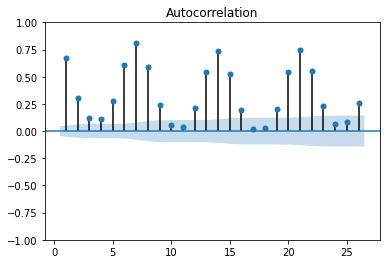

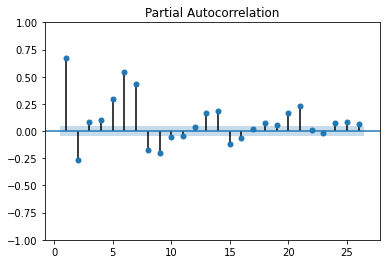

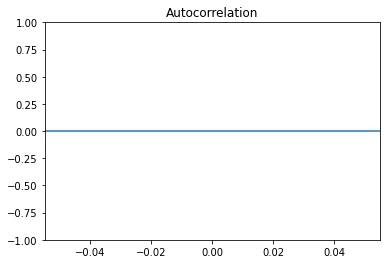

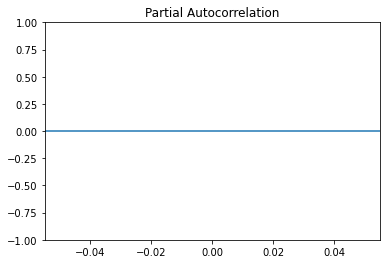

In [93]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plot_acf(model_df['unit_sale'], lags = 26,zero=False);
plot_pacf(model_df['unit_sale'], lags = 26,zero=False);

plot_acf(model_df['unit_sale_diff'], lags = 5,zero=False);

plot_pacf(model_df['unit_sale_diff'], lags = 5,zero=False);

In [41]:
model_df['adj_log'] = np.log(model_df['unit_sale'])
model_df['adj_log_diff'] = model_df['adj_log'] - model_df['adj_log'].shift(1)

In [42]:
ad_test(model_df['adj_log_diff'].dropna())

1 ADF -16.90818687035629
2 p-value 1.015450160805644e-29
3 Number of lags 26
4-Number of observation used for regression and critical values calculations 1885
5-Critical values: 1%,5%,10% {'1%': -3.4338238606869878, '5%': -2.863074513221476, '10%': -2.5675869178703854}


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


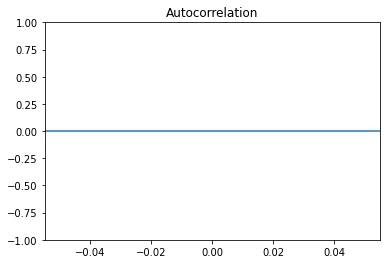

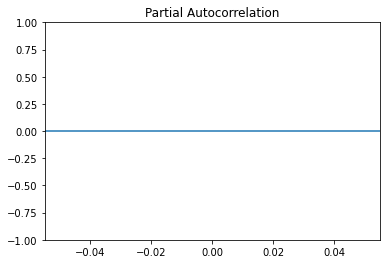

In [92]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plot_acf(model_df['adj_log_diff'], lags = 5,zero=False);
plot_pacf(model_df['adj_log_diff'], lags = 5,zero=False);

In [43]:
model_df['adj_sqrt'] = np.sqrt(model_df['unit_sale'])
model_df['adj_sqrt_diff'] = model_df['adj_sqrt'] - model_df['adj_sqrt'].shift(1)

In [45]:
ad_test(model_df['adj_sqrt_diff'].dropna())

1 ADF -22.349402845649962
2 p-value 0.0
3 Number of lags 26
4-Number of observation used for regression and critical values calculations 1885
5-Critical values: 1%,5%,10% {'1%': -3.4338238606869878, '5%': -2.863074513221476, '10%': -2.5675869178703854}


It looks like all efforts for stationary timeseries result in missing AR and PAR. Need to discuss with professor?

#Split Training and Validation

In [94]:
training_df = model_df[['unit_sale']].iloc[0:model_df.shape[0] - 28]
validation_df = model_df[['unit_sale']].iloc[model_df.shape[0] - 28:model_df.shape[0]]

#Auto ARIMA

In [95]:
model = pm.auto_arima(training_df['unit_sale'].dropna(), start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=38072.056, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=44796.230, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=38085.388, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=42535.073, Time=0.49 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=38052.408, Time=0.63 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=38079.697, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=37232.062, Time=2.08 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=3.62 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=37385.591, Time=1.50 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=37615.186, Time=1.04 sec

Best model:  ARIMA(3,0,1)(0,0,0)[0]          
Total fit time: 9.976 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 18

#ARIMA model

In [107]:
model = ARIMA(training_df['unit_sale'].dropna(), order=(3,0,1))
model = model.fit()

model.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              unit_sale   No. Observations:                 1885
Model:                 ARIMA(3, 0, 1)   Log Likelihood              -18625.314
Date:                Sun, 03 Oct 2021   AIC                          37262.628
Time:                        03:47:38   BIC                          37295.879
Sample:                    01-29-2011   HQIC                         37274.874
                         - 03-27-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.422e+04   6008.533      5.696      0.000    2.24e+04     4.6e+04
ar.L1          1.6839      0.017     97.777      0.000       1.650       1.718
ar.L2         -1.1118      0.026    -43.459      0.000      -1.162      -1.062
ar.L3          0.4273      0.018     23.867      0.000       0.392       0.462
ma.L1         -0.9636      0.009   -105.111      0.000      -0.982      -0.946
sigma2      2.699e+07      8.612   3.13e+06      0.000     2.7e+07     2.7e+07
===================================================================================
Ljung-Box (L1) (Q):                  11.77   Jarque-Bera (JB):              3572.98
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.78   Skew:                            -0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.71e+21. Standard errors may be unstable.
"""

In [131]:
start = len(training_df)
end = len(training_df)+len(validation_df)-1
pred = model.predict(start=start,end=end,typ='levels')

In [132]:
pred

2016-03-28    39344.795632
2016-03-29    37745.543180
2016-03-30    39646.151445
2016-03-31    41627.104164
2016-04-01    42166.369085
2016-04-02    41684.112568
2016-04-03    41118.927717
2016-04-04    40933.813847
2016-04-05    41044.413472
2016-04-06    41194.964175
2016-04-07    41246.413150
2016-04-08    41212.922934
2016-04-09    41163.656575
2016-04-10    41139.915470
2016-04-11    41140.402516
2016-04-12    41146.567115
2016-04-13    41146.261828
2016-04-14    41139.102055
2016-04-15    41130.019263
2016-04-16    41122.554645
2016-04-17    41117.024026
2016-04-18    41112.129279
2016-04-19    41106.846471
2016-04-20    41101.029624
2016-04-21    41095.016662
2016-04-22    41089.101394
2016-04-23    41083.340485
2016-04-24    41077.647086
Freq: D, Name: predicted_mean, dtype: float64

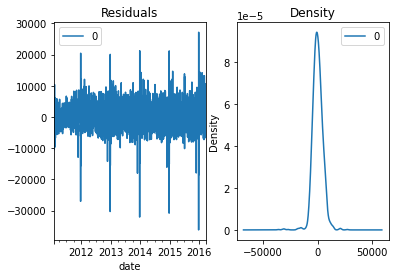

In [133]:
residuals = pd.DataFrame(model.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

The residual is distributed around mean of 0.

In [134]:
validation_df['F_ARIMA']= pred

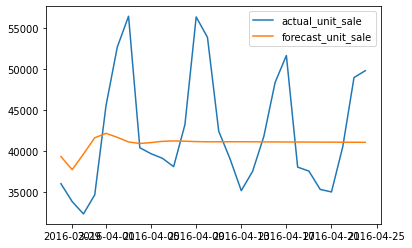

In [135]:
plt.plot(validation_df)
plt.legend(['actual_unit_sale','forecast_unit_sale'])

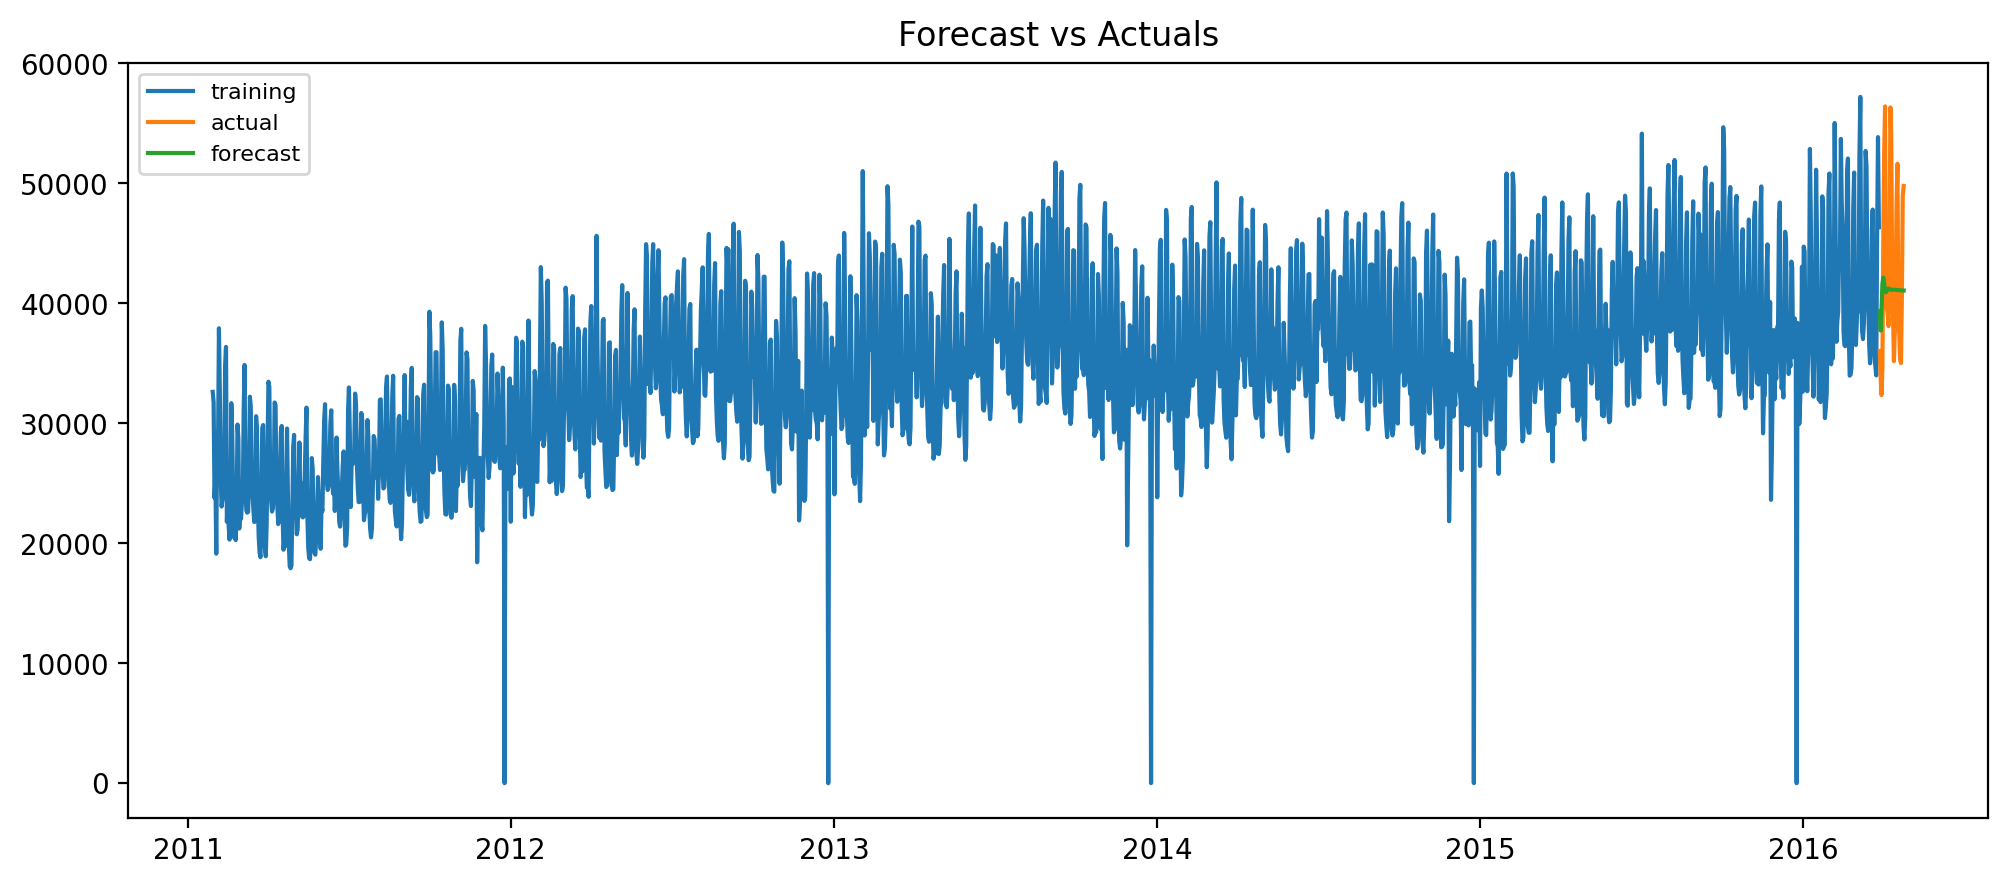

In [136]:
plt.figure(figsize=(12,5), dpi=200)
plt.plot(training_df['unit_sale'], label='training')
plt.plot(validation_df['unit_sale'], label='actual')
plt.plot(pred, label='forecast')

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [138]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

In [139]:
forecast_accuracy(validation_df['F_ARIMA'],validation_df['unit_sale'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed 

{'corr': 0.37790316154638864,
 'mae': 5535.155754359445,
 'mape': 0.12493463888162659,
 'me': -1312.4947905358679,
 'minmax': 0.11769486782749816,
 'mpe': -0.006589377027784232,
 'rmse': 6954.225637665911}

MAPE = 0.124

Estimation using RMSSE

In [140]:
df["last28_mean"] = df[[c for c in df.columns if c.find("d_")==0 and\
        int(c.split("_")[1]) in range(1858, 1886)] +\
       ["id"]].set_index("id").transpose().mean().reset_index()[0]

In [142]:
agg_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/m5-forecasting-accuracy/top_down_agg_levels.csv',sep=',')

In [144]:
agg_df.drop('Unnamed: 0',axis=1,inplace=True)

In [147]:
this_level_df = agg_df[agg_df["level"]==1].copy()
for d in range(1, 29):
  this_level_df["F_" + str(1) + "_" + str(1885 + d)] = pred[d-1]
  

In [158]:
for i, row in this_level_df.iterrows():
          level_mean_with_cond = this_level_df[[c for c in df.columns if c.find("d_")==0 and\
                                   int(c.split("_")[1]) in range(1858, 1886)]].transpose().mean()[0]
          proportion = df["last28_mean"] / level_mean_with_cond 
          for d in range(1, 29):
              df["F_" + str(1) + "_" + str(1885 + d)] = list(this_level_df["F_" + str(1) + "_" + str(1885 + d)])[0] * proportion

In [161]:
level_groupings = {2:["state_id"], 3:["store_id"], 4:["cat_id"], 5:["dept_id"],
                  6:["state_id","cat_id"],7:["state_id","dept_id"],
                  8:["store_id","cat_id"], 9:["store_id","dept_id"],
                  10:["item_id"], 11:["item_id","state_id"]}

new_agg_df = pd.DataFrame(df[[c for c in df.columns if c.find("d_") == 0 or c.find("F_") == 0]].sum()).transpose()
id_cols = ["item_id", "dept_id", "cat_id", "store_id", "state_id"]
for col in id_cols:
    new_agg_df[col] = 'all'
new_agg_df["level"] = 1
new_agg_df["weight"] = 1/12
column_order = new_agg_df.columns

for level in level_groupings:
    temp_df = df.groupby(by=level_groupings[level]).sum().reset_index()
    temp_df["level"] = level
    for c in column_order:
        if c not in temp_df.columns:
            temp_df[c] = 'all'
    new_agg_df = new_agg_df.append(temp_df[column_order])
del temp_df

In [171]:
train_series_cols = [c for c in df.columns if c.find("d_") == 0][:-28]
ground_truth_cols = [c for c in df.columns if c.find("d_") == 0][-28:]

forecast_cols_dict = {}
forecast_cols_dict[1] = [c for c in df.columns if c.find("F_"+str(1)+"_") == 0]

In [202]:
df["rmsse_" + str(1)+'_tp'] = rmsse(np.array(df[ground_truth_cols]), 
        np.array(df[forecast_cols_dict[1]]), np.array(df[train_series_cols]))
new_agg_df["rmsse_" + str(1)+'_tp'] = rmsse(np.array(new_agg_df[ground_truth_cols]), 
        np.array(new_agg_df[forecast_cols_dict[1]]), np.array(new_agg_df[train_series_cols]))
df["wrmsse_" + str(1)+'_tp'] = agg_df[agg_df["level"]==1]["weight"] * df["rmsse_" + str(1)+'_tp']


In [203]:
 series = np.array(agg_df["weight"] * new_agg_df["rmsse_" + str(1)+'_tp'])

In [207]:
new_agg_df["wrmsse_" + str(1)+'_tp'] =series[0:12350]

In [210]:
print("Aggregation by level", str(1) + ":")
print(df["wrmsse_" + str(1)+'_tp'].sum()+ new_agg_df["wrmsse_" + str(1)+'_tp'].sum())

Aggregation by level 1:
4.231492730261814


In [163]:
h = 28
n = 1885
def rmsse(ground_truth, forecast, train_series, axis=1):
    # assuming input are numpy array or matrices
    assert axis == 0 or axis == 1
    assert type(ground_truth) == np.ndarray and type(forecast) == np.ndarray and type(train_series) == np.ndarray
    
    if axis == 1:
        # using axis == 1 we must guarantee these are matrices and not arrays
        assert ground_truth.shape[1] > 1 and forecast.shape[1] > 1 and train_series.shape[1] > 1
    
    numerator = ((ground_truth - forecast)**2).sum(axis=axis)
    if axis == 1:
        denominator = 1/(n-1) * ((train_series[:, 1:] - train_series[:, :-1]) ** 2).sum(axis=axis)
    else:
        denominator = 1/(n-1) * ((train_series[1:] - train_series[:-1]) ** 2).sum(axis=axis)
    return (1/h * numerator/denominator) ** 0.5